# Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

training_variables = util.training_variables
columns = util.all_relevant_variables

Welcome to JupyROOT 6.26/14


In [2]:
# 4S_offres Data vs MC, regions: BDT conti, sig, no sig

# Load data files
MC_4S = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb_control/*.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

MC_4Soffres = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/4Soffres_quaxo_3.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

data_4Soffres = uproot.concatenate([f'../../Samples/Data/e_channel/*4Soffres_quaxo_1.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

df_mc_4S = pd.DataFrame(MC_4S)
df_mc_4Soffres = pd.DataFrame(MC_4Soffres)
df_data_4Soffres = pd.DataFrame(data_4Soffres)

BDT_continuum='signal_prob<0.3 and continuum_prob>0.8 and fakeD_prob<0.05'
BDT_sig='signal_prob==largest_prob and signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05'
BDT_no_sig = 'signal_prob<0.3'

In [3]:
for df in [df_mc_4S, df_mc_4Soffres,df_data_4Soffres,]: #df_mc_4S,df_data_4S]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [4]:
# BCS
df_mc_4S_BDT_sig = util.apply_mva_bcs(df_mc_4S, training_variables, BDT_sig)
df_mc_4Soffres_BDT_sig = util.apply_mva_bcs(df_mc_4Soffres, training_variables, BDT_sig)
df_data_4Soffres_BDT_sig = util.apply_mva_bcs(df_data_4Soffres, training_variables, BDT_sig)

In [30]:
# BCS, conti enhanced
df_mc_4S_BDT_conti = util.apply_mva_bcs(df_mc_4S, training_variables, BDT_continuum)
df_mc_4Soffres_BDT_conti = util.apply_mva_bcs(df_mc_4Soffres, training_variables, BDT_continuum)
df_data_4Soffres_BDT_conti = util.apply_mva_bcs(df_data_4Soffres, training_variables, BDT_continuum)

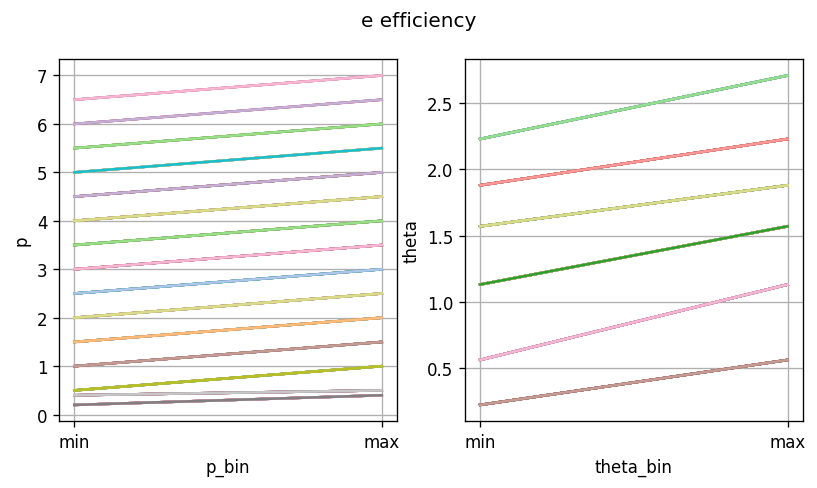

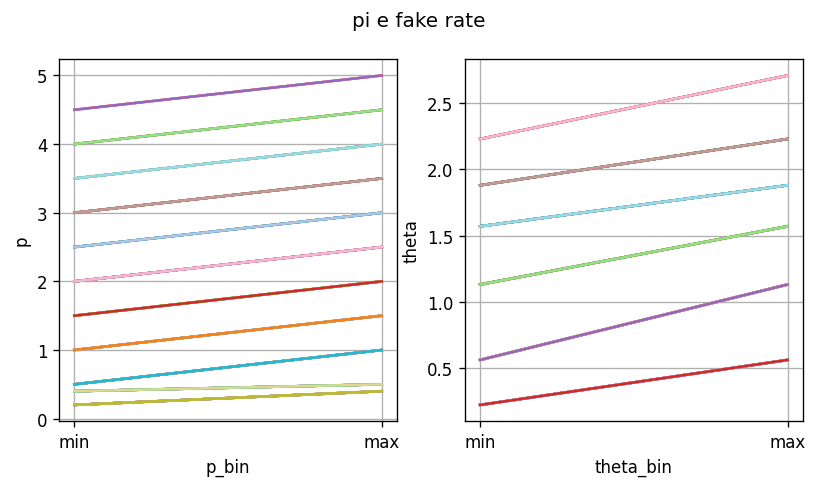

In [5]:
# PID corrections, get tables
pid = util.PID_corrections()
exclude_e_bins_query = "not (p_min == 0.2 and p_max == 5.0) \
and not (theta_min == 0.22 and theta_max == 2.71) \
and not (theta_min == 0.56 and theta_max == 2.23)"
e_eff, e_fake = pid.get_lepton_tables(lepton='e', var="pidChargedBDTScore_e",
                          thres=0.9, exclude_bins=exclude_e_bins_query)
K_eff, K_fake = pid.get_hadron_tables(new_table=False, hadron='K', var='kaonIDNN', thres=0.9)

Required variables: ['ell_theta', 'ell_charge', 'ell_p', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 96.2%
Required variables: ['D_K_p', 'D_K_charge', 'D_K_cosTheta', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 95.5%
Required variables: ['ell_theta', 'ell_charge', 'ell_p', 'ell_PDG', 'ell_mcPDG']


/tmp/ipykernel_354373/1904807238.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)


Coverage:
PID ell: 87.7%
Required variables: ['D_K_p', 'D_K_charge', 'D_K_cosTheta', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 87.3%


/tmp/ipykernel_354373/1904807238.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)


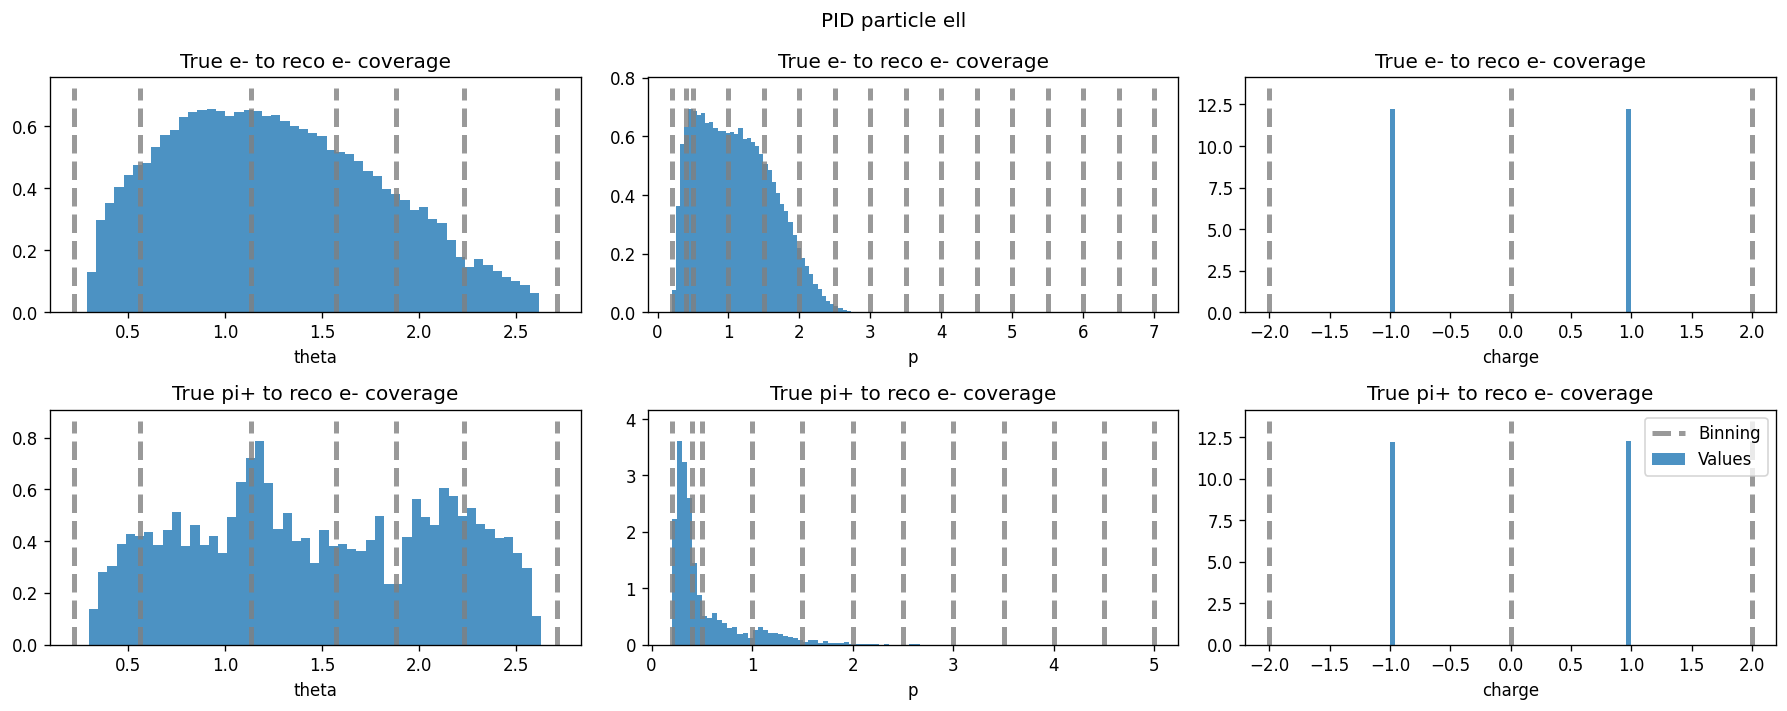

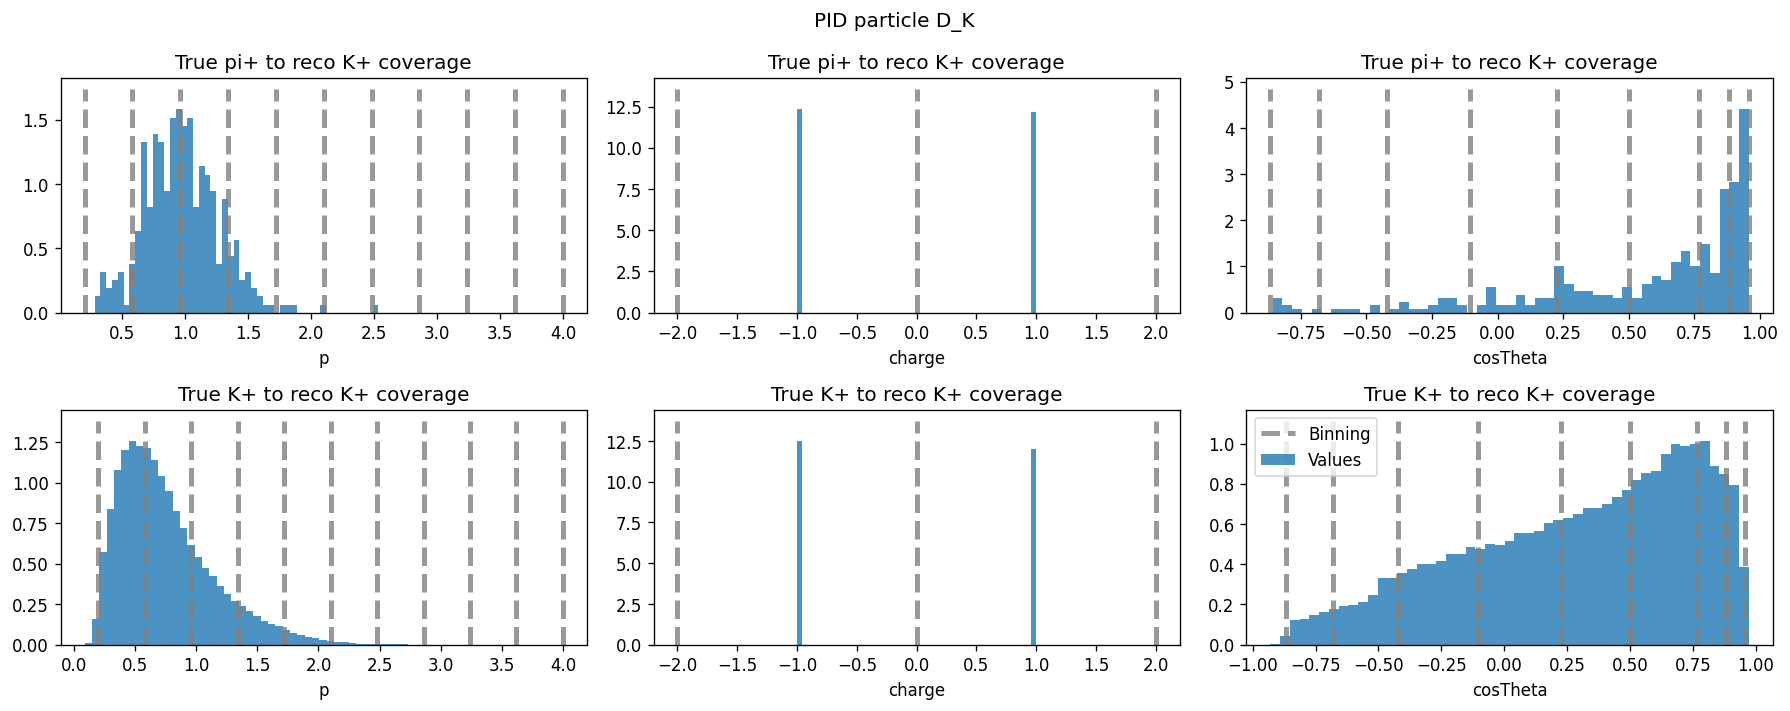

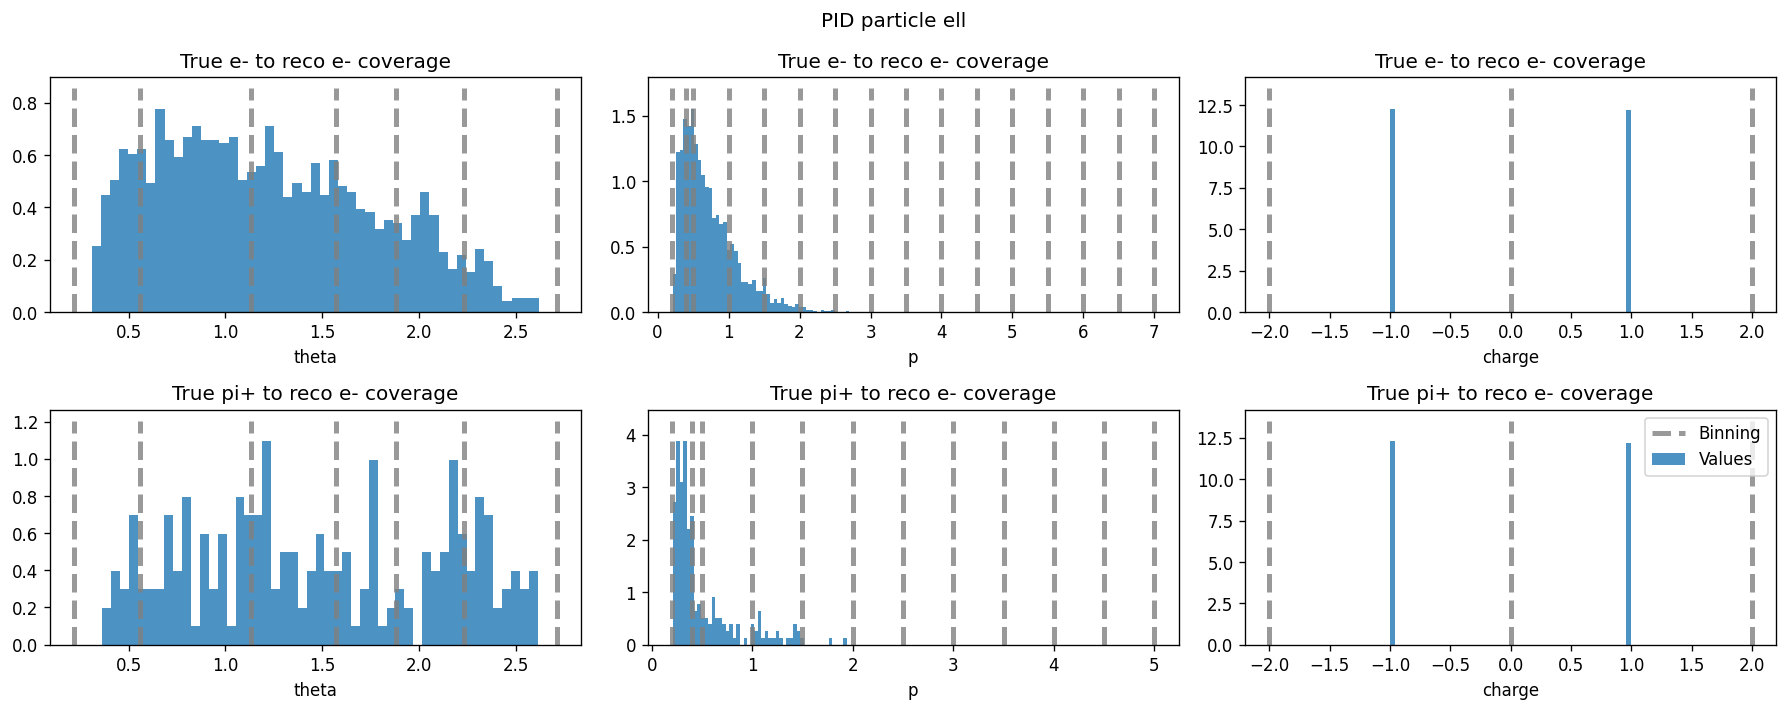

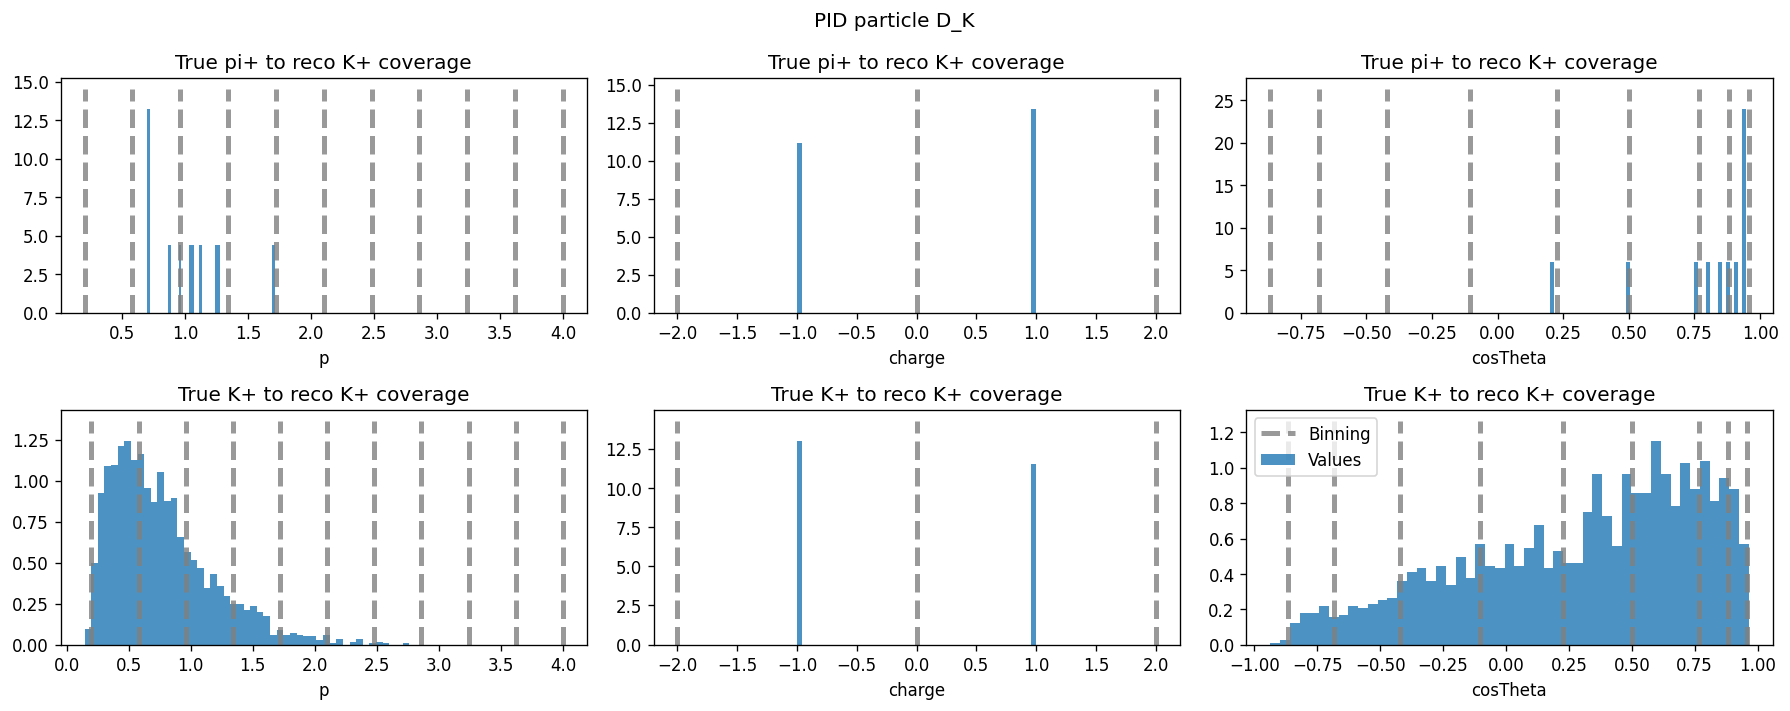

In [6]:
# Apply PID corrections
for df in [df_mc_4S_BDT_sig, df_mc_4Soffres_BDT_sig]:
    pid.apply_corrections(eff_table=e_eff, fake_table=e_fake, df=df, plots=True,
                          p='e', var='pidChargedBDTScore_e', thres=0.9)
    pid.apply_corrections(eff_table=K_eff, fake_table=K_fake, df=df, plots=True,
                          p='K', var='kaonIDNN', thres=0.9)
    df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)
    df = df.copy()

Required variables: ['ell_p', 'ell_theta', 'ell_charge', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 94.9%
Required variables: ['D_K_p', 'D_K_charge', 'D_K_cosTheta', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 94.5%
Required variables: ['ell_p', 'ell_theta', 'ell_charge', 'ell_PDG', 'ell_mcPDG']


/tmp/ipykernel_408286/2999172047.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)


Coverage:
PID ell: 87.7%
Required variables: ['D_K_p', 'D_K_charge', 'D_K_cosTheta', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 88.8%


/tmp/ipykernel_408286/2999172047.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)


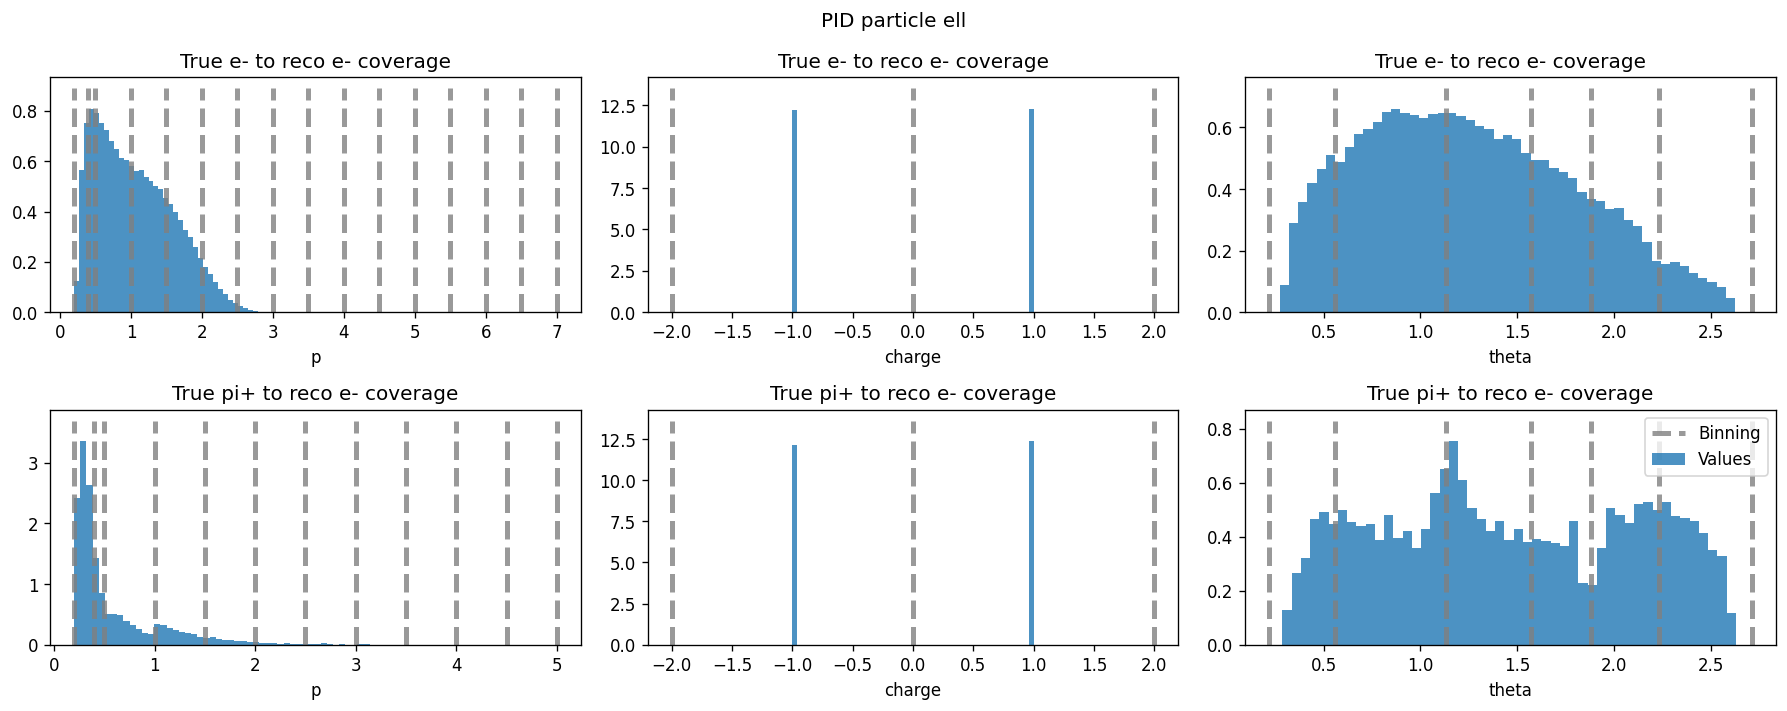

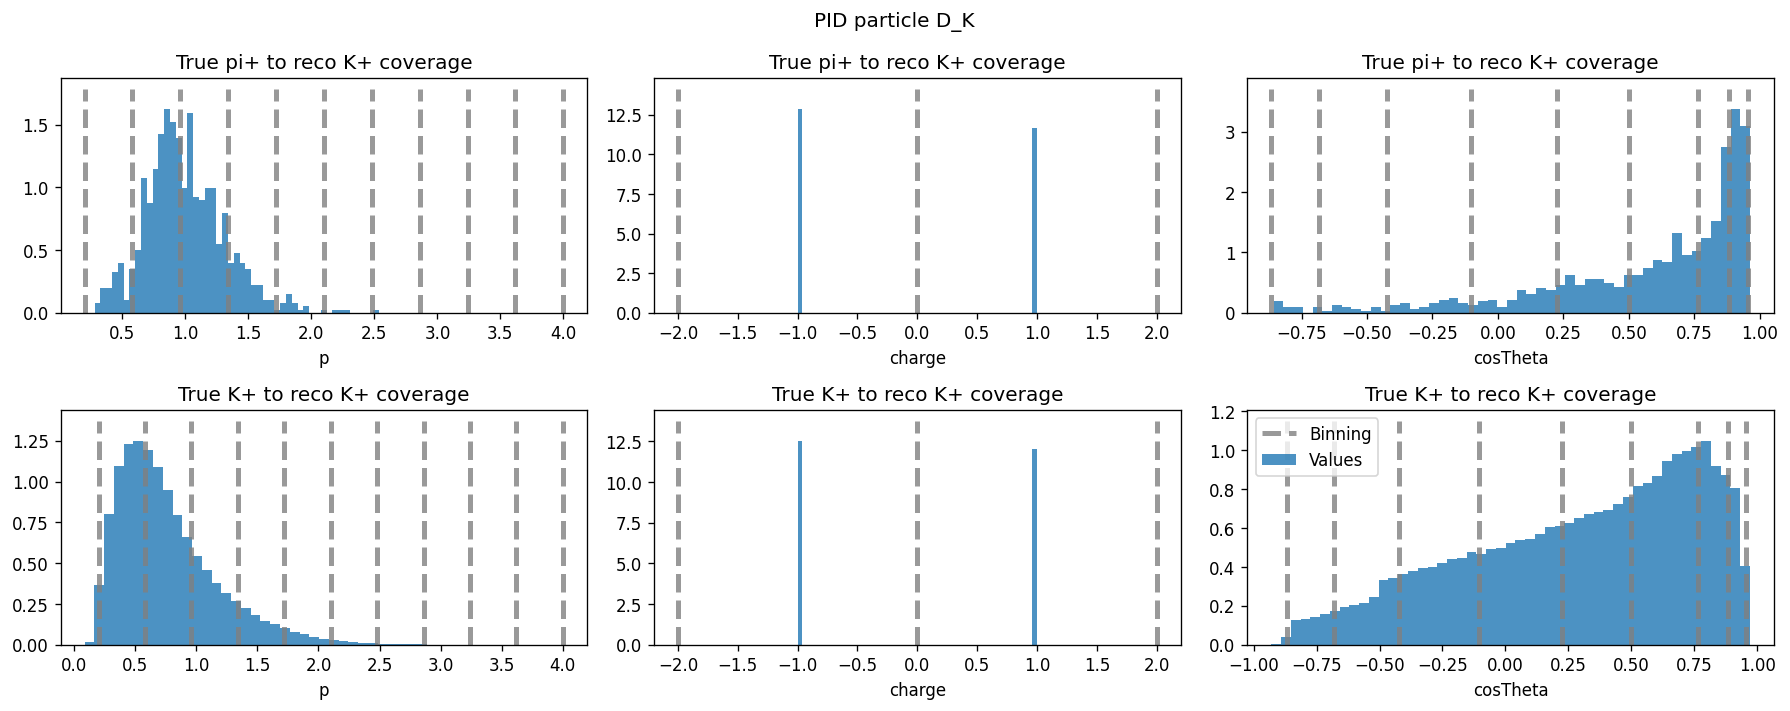

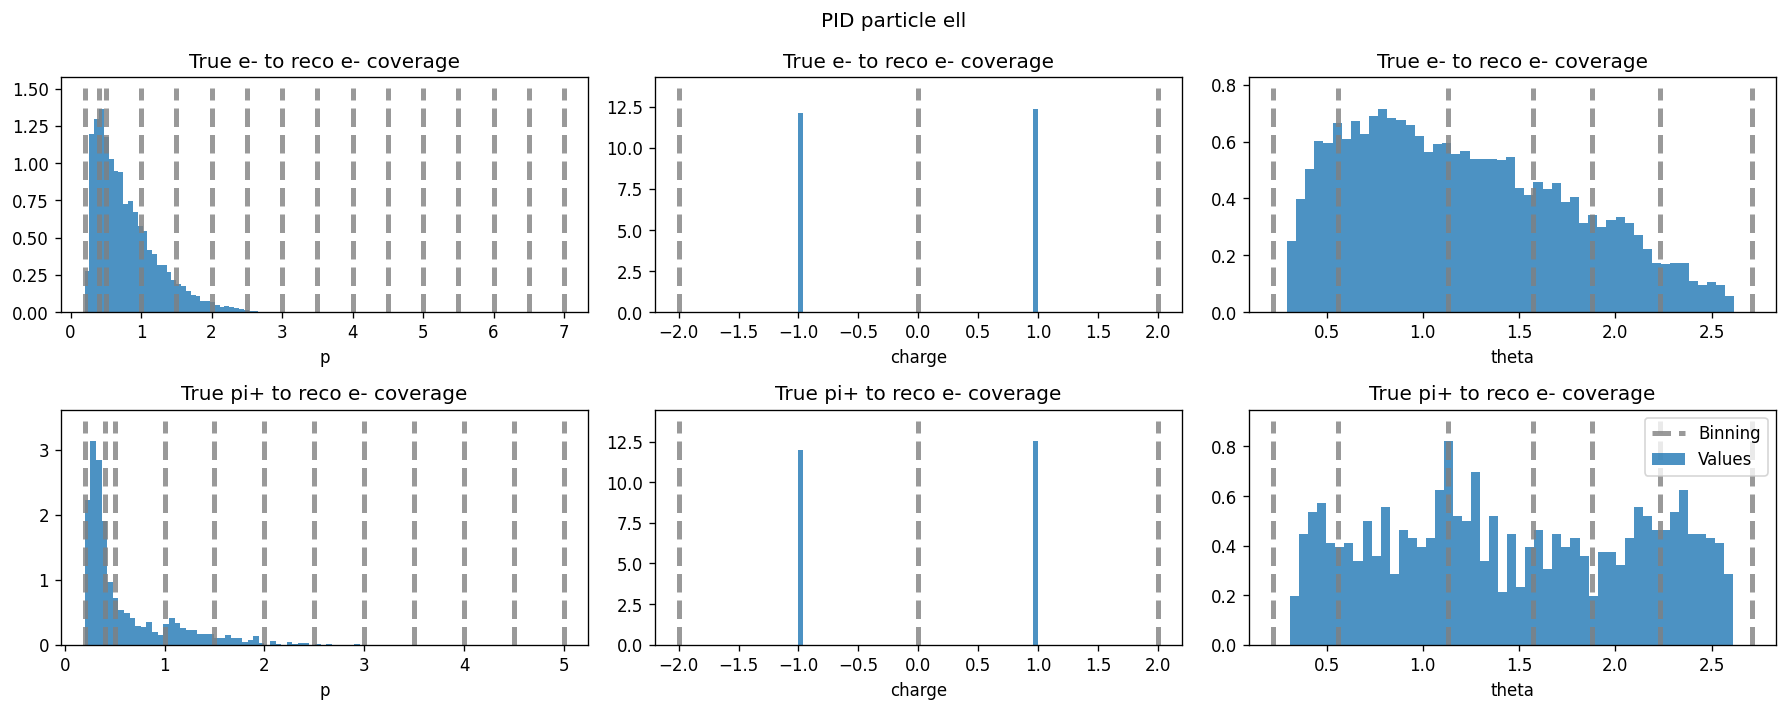

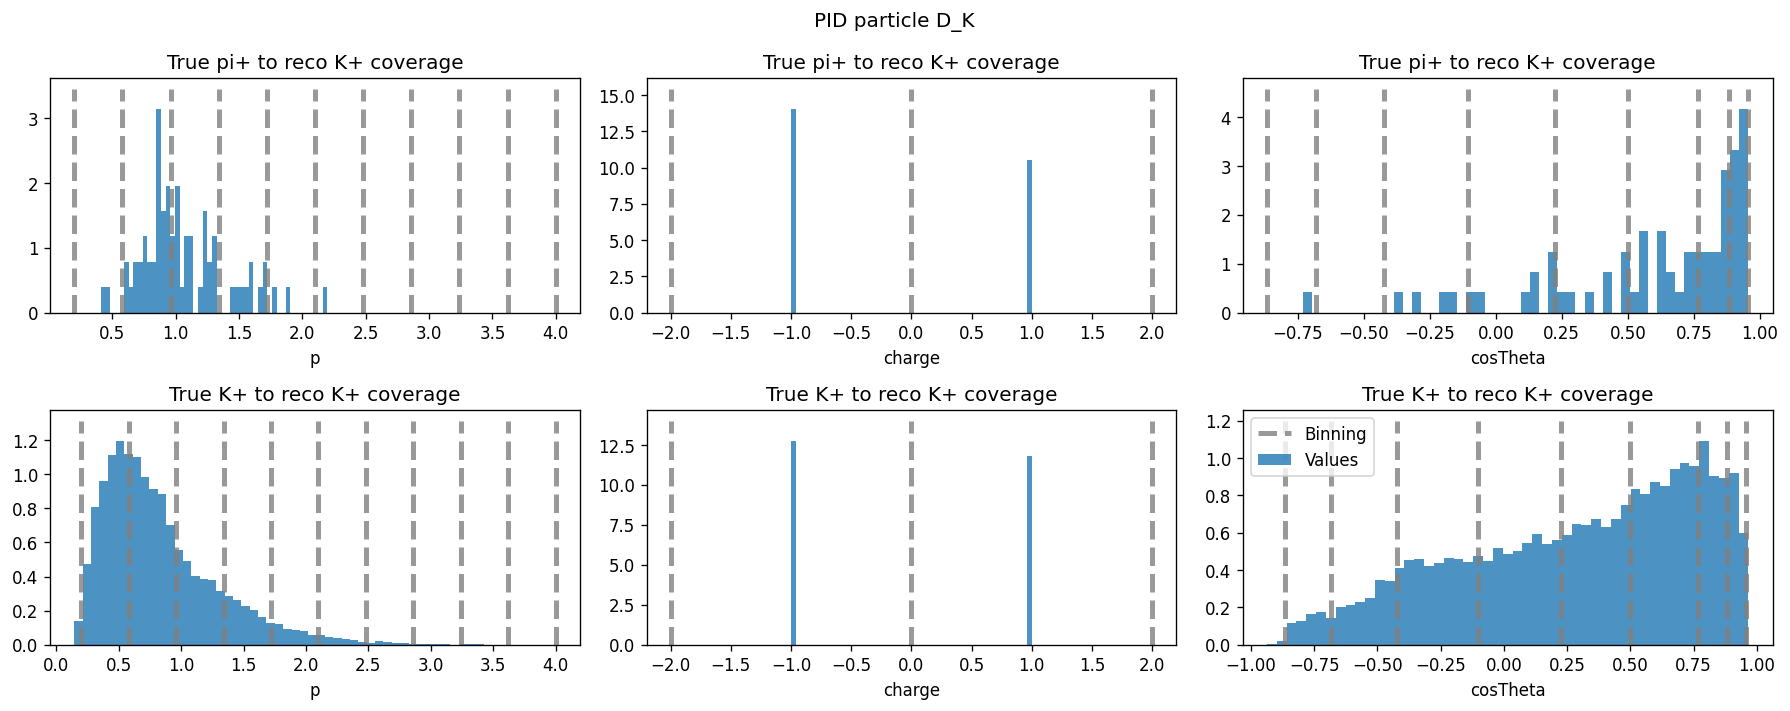

In [32]:
# Apply PID corrections
for df in [df_mc_4S_BDT_conti, df_mc_4Soffres_BDT_conti]:
    pid.apply_corrections(eff_table=e_eff, fake_table=e_fake, df=df, plots=True,
                          p='e', var='pidChargedBDTScore_e', thres=0.9)
    pid.apply_corrections(eff_table=K_eff, fake_table=K_fake, df=df, plots=True,
                          p='K', var='kaonIDNN', thres=0.9)
    df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)
    df = df.copy()

In [7]:
columns_without_nan = df_data_4Soffres_BDT_sig.columns[~df_data_4Soffres_BDT_sig.isna().any()].tolist()

samples_control=util.get_dataframe_samples_new(df_mc_4Soffres_BDT_sig, 'e', template=False)
samples_sig = util.get_dataframe_samples_new(df_mc_4S_BDT_sig, 'e', template=False)
mpl=util.mpl(samples_control,df_data_4Soffres_BDT_sig)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples_control.items():
    print(name, len(df))

bkg_FakeD 1679
bkg_TDFl 71
bkg_fakeTracks 43
bkg_continuum 643
bkg_combinatorial 0
bkg_singleBbkg 0
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$ 0
$D\ell\nu$_gap 0
bkg_other_signal 0


In [33]:
columns_without_nan = df_data_4Soffres_BDT_conti.columns[~df_data_4Soffres_BDT_conti.isna().any()].tolist()

samples_control=util.get_dataframe_samples_new(df_mc_4Soffres_BDT_conti, 'e', template=False)
samples_sig = util.get_dataframe_samples_new(df_mc_4S_BDT_conti, 'e', template=False)
mpl=util.mpl(samples_control,df_data_4Soffres_BDT_conti)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples_control.items():
    print(name, len(df))

bkg_FakeD 9008
bkg_TDFl 525
bkg_fakeTracks 214
bkg_continuum 3619
bkg_combinatorial 0
bkg_singleBbkg 0
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$ 0
$D\ell\nu$_gap 0
bkg_other_signal 0


# Check 4S vs. 4S_offres

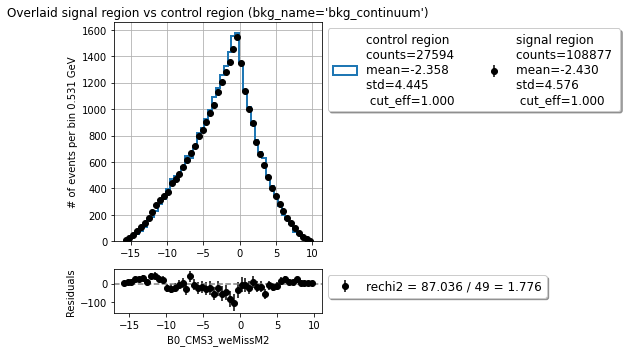

In [18]:
# compare control vs signal regions MC
b1 = np.linspace(-16,10,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

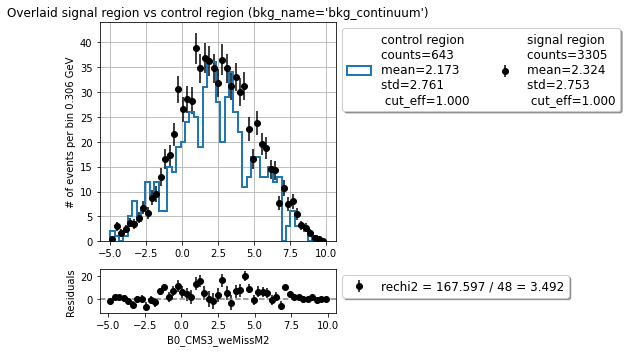

In [6]:
# compare control vs signal regions MC
b1 = np.linspace(-5,10,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

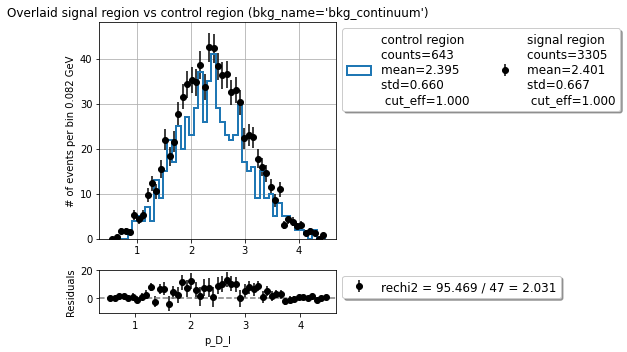

In [11]:
b2 = np.linspace(0.5,4.5,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

# Check Data vs. MC

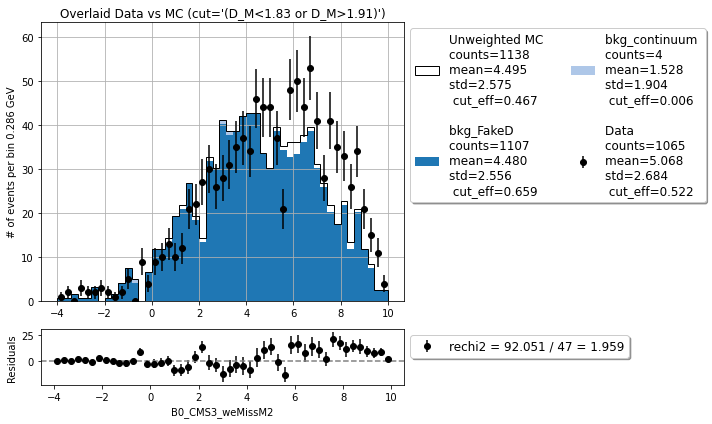

In [9]:
# sidebands
b1 = np.linspace(-4,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,42/50],correction=True,mask=[],ratio=False)

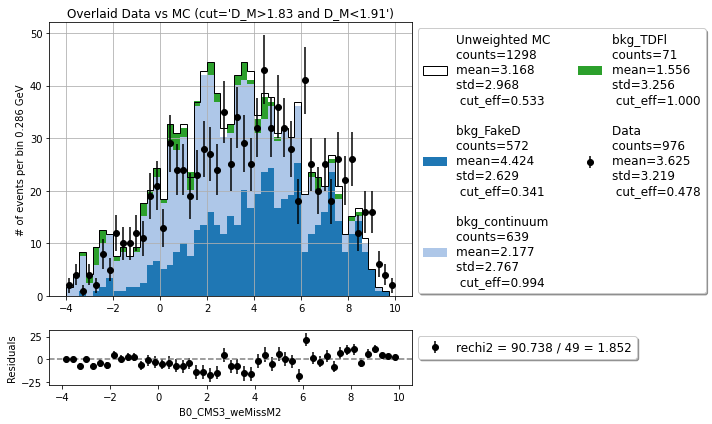

In [10]:
# signal
b1 = np.linspace(-4,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='D_M>1.83 and D_M<1.91',
                          scale=[1,42/50],correction=True,mask=[],ratio=False)

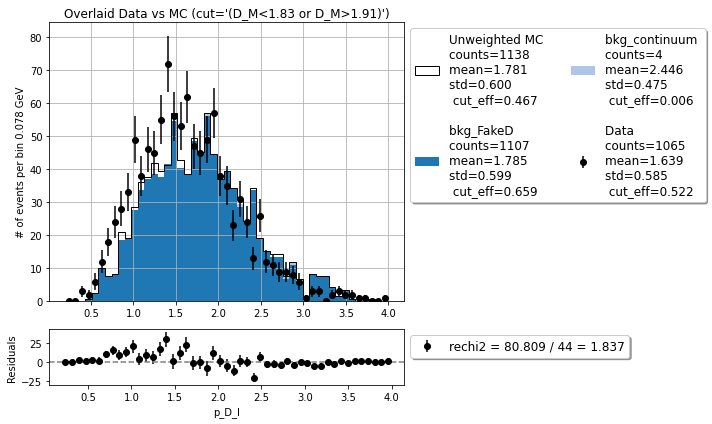

In [11]:
# sidebands
b2 = np.linspace(0.2,4,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,figsize=(10,6),
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,42/50],correction=True,mask=[],ratio=False)

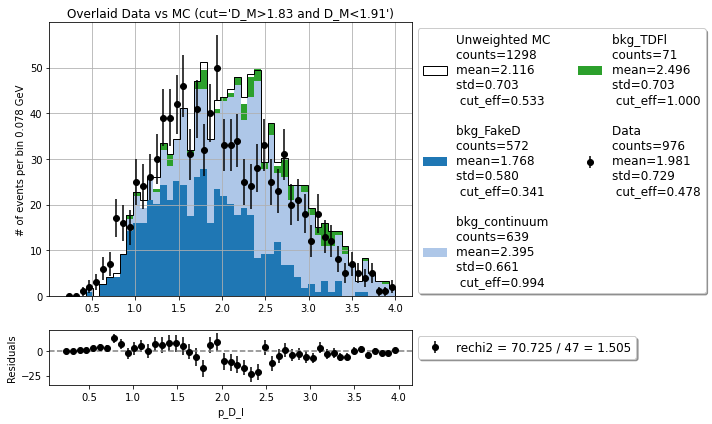

In [12]:
# signal
b2 = np.linspace(0.2,4,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,figsize=(10,6),
                          cut='D_M>1.83 and D_M<1.91',
                          scale=[1,42/50],correction=True,mask=[],ratio=False)

# Create data driven template for continuum
## 1. Calculate the sidebands to sig region scaling factors
### a. Histogram the D_M distribution

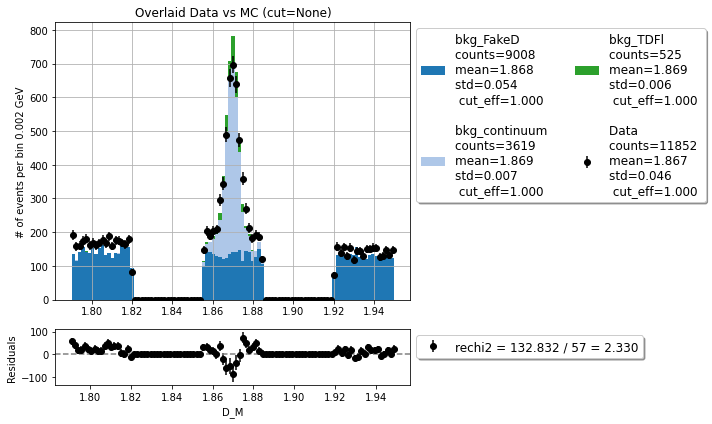

In [34]:
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,
                                                      scale=[1,42/50],correction=False,
                                                      mask=[],figsize=(10,6),ratio=False)

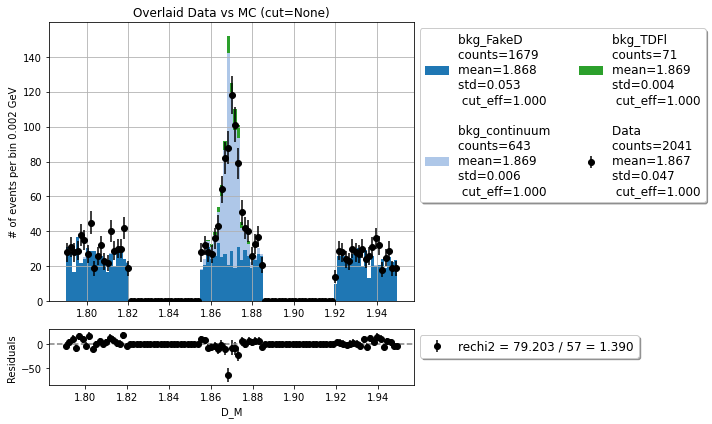

In [8]:
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,
                                                      scale=[1,42/50],correction=False,
                                                      mask=[],figsize=(10,6),ratio=False)

### b. fit the FakeD with a polynomial

In [9]:
fitter = util.fit_iminuit(x_edges=b1, hist=mc_hist_all, poly_only=False)

In [ ]:
m_ls, c_ls, result_ls = fitter.fit_gauss_poly_LS(deg=1, loss='linear') #'soft_l1'
m_ls
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 8.4000e+00  1.8700e+00  5.0000e-02 -3.8050e+02  1.1337e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 65.24 (χ²/ndof = 1.4)      │              Nfcn = 418              │
│ EDM = 2.05e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   7.47    │   0.19    │            │            │    0    │         │       │
│ 1 │ x1   │  1.87038  │  0.00010  │            │            │    0    │         │       │
│ 2 │ x2   │  3.73e-3  │  0.11e-3  │            │            │    0    │         │       │
│ 3 │ x3   │   -480    │    60     │            │            │         │         │       │
│ 4 │ x4   │  1.57e3   │  0.11e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │          x0          x1          x2          x3          x4 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │      0.0357     -515e-9   10.593e-6        0.26       -0.79 │
│ x1 │     -515e-9    9.45e-09       -1e-9 -204.590e-6  388.641e-6 │
│ x2 │   10.593e-6       -1e-9    1.14e-08  112.253e-6 -332.788e-6 │
│ x3 │        0.26 -204.590e-6  112.253e-6    3.52e+03      -6.6e3 │
│ x4 │       -0.79  388.641e-6 -332.788e-6      -6.6e3    1.24e+04 │
└────┴─────────────────────────────────────────────────────────────┘

In [10]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 4.17510e+03  1.87000e+00  5.00000e-02  4.17514e+04 -3.80500e+02
  1.13300e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 55.92 (χ²/ndof = 1.2)      │              Nfcn = 395              │
│ EDM = 3.31e-06 (Goal: 0.0002)    │            time = 1.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  4.62e3   │  0.13e3   │            │            │    0    │         │       │
│ 1 │ x1   │  1.86957  │  0.00011  │            │            │    0    │         │       │
│ 2 │ x2   │  3.70e-3  │  0.12e-3  │            │            │    0    │         │       │
│ 3 │ x3   │  65.9e3   │   0.4e3   │            │            │         │         │       │
│ 4 │ x4   │  -0.14e3  │  0.12e3   │            │            │         │         │       │
│ 5 │ x5   │   0.5e3   │   0.4e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────┐
│    │            x0            x1            x2            x3            x4            x5 │
├────┼─────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │      1.66e+04   -447.387e-6   8.082984e-3      -0.022e6             0             0 │
│ x1 │   -447.387e-6      1.15e-08     -0.001e-6    820.839e-6    -16.855e-6    -47.083e-6 │
│ x2 │   8.082984e-3     -0.001e-6      1.37e-08 -14.991377e-3      2.523e-6      6.994e-6 │
│ x3 │      -0.022e6    820.839e-6 -14.991377e-3      1.65e+05            -0            -0 │
│ x4 │             0    -16.855e-6      2.523e-6            -0      1.44e+04      -0.047e6 │
│ x5 │             0    -47.083e-6      6.994e-6            -0      -0.047e6      1.51e+05 │
└────┴─────────────────────────────────────────────────────────────────────────────────────┘

In [10]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 2.0100e+02  1.8700e+00  4.0000e-02  2.0101e+03 -1.7400e+01  5.2800e+01]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 48.71 (chi2/ndof = 1.0)    │              Nfcn = 396              │
│ EDM = 1.84e-05 (Goal: 0.0002)    │           time = 14.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    584    │    32     │            │            │    0    │         │       │
│ 1 │ x1   │  1.8695   │  0.0002   │            │            │    0    │         │       │
│ 2 │ x2   │  3.44e-3  │  0.20e-3  │            │            │    0    │         │       │
│ 3 │ x3   │  2.52e3   │  0.08e3   │            │            │         │         │       │
│ 4 │ x4   │    -12    │    23     │            │            │         │         │       │
│ 5 │ x5   │    40     │    80     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │  1.02e+03 -0.000262    0.0025      -814     0.348     0.931 │
│ x1 │ -0.000262  4.14e-08  -3.3e-09  0.000486  -1.2e-05 -3.21e-05 │
│ x2 │    0.0025  -3.3e-09  4.16e-08  -0.00465  2.94e-06  7.86e-06 │
│ x3 │      -814  0.000486  -0.00465  6.22e+03    -0.649     -1.73 │
│ x4 │     0.348  -1.2e-05  2.94e-06    -0.649       550 -1.76e+03 │
│ x5 │     0.931 -3.21e-05  7.86e-06     -1.73 -1.76e+03  5.77e+03 │
└────┴─────────────────────────────────────────────────────────────┘

### c. Calculate the yield ratio

In [ ]:
area_left,error_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ls)
area_sig, error_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ls)
area_right,error_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ls)

In [11]:
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

Yields from 1.79 to 1.82: 494.714
Yields from 1.855 to 1.885: 472.318
Yields from 1.92 to 1.95: 449.922


In [12]:
a = len(samples_control['bkg_FakeD'].query('1.79<D_M<1.82')) * 42/50
b = len(samples_control['bkg_FakeD'].query('1.92<D_M<1.95')) * 42/50
print('truth',a,b, a/b)

truth 488.88 441.0 1.1085714285714285


### d. Plot and compare MC of the weighted sideband and signal region

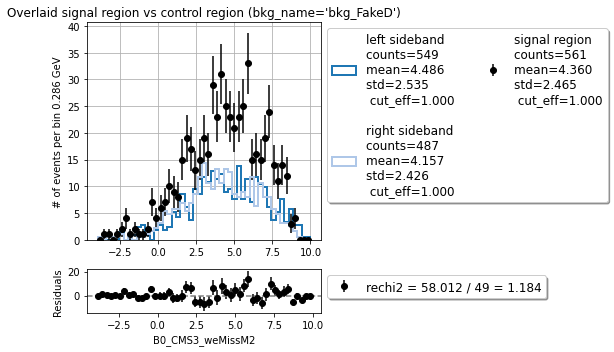

In [16]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=False,
                        scale=scale,correction=False,mask=[])

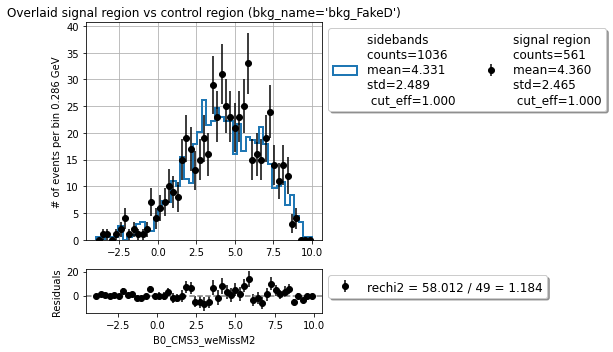

In [16]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[])

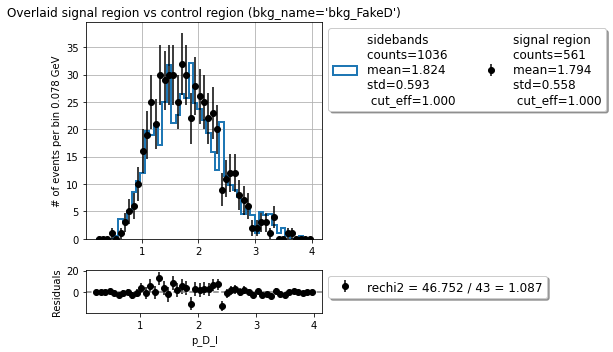

In [17]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut=None,
                        scale=scale,correction=False,mask=[])

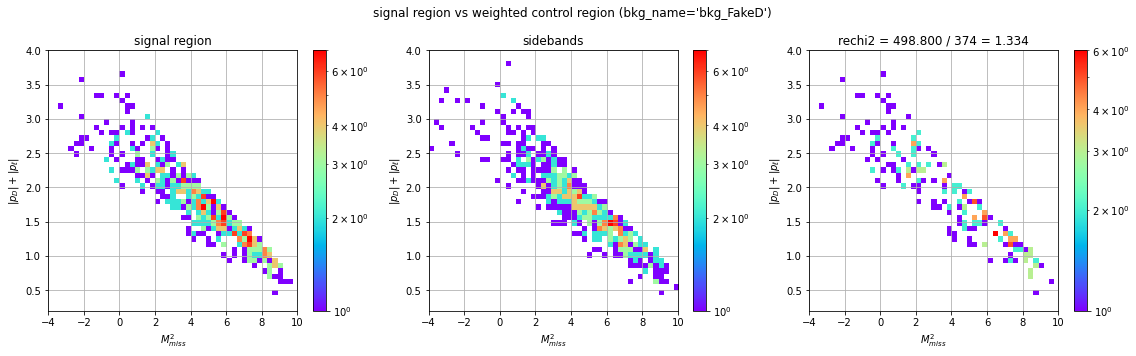

In [15]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable=['B0_CMS3_weMissM2','p_D_l'],
                        bins=[b1,b2],
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=True,mask=[],figsize=(16,5))

## 2. Subtract the FakeD from the signal region

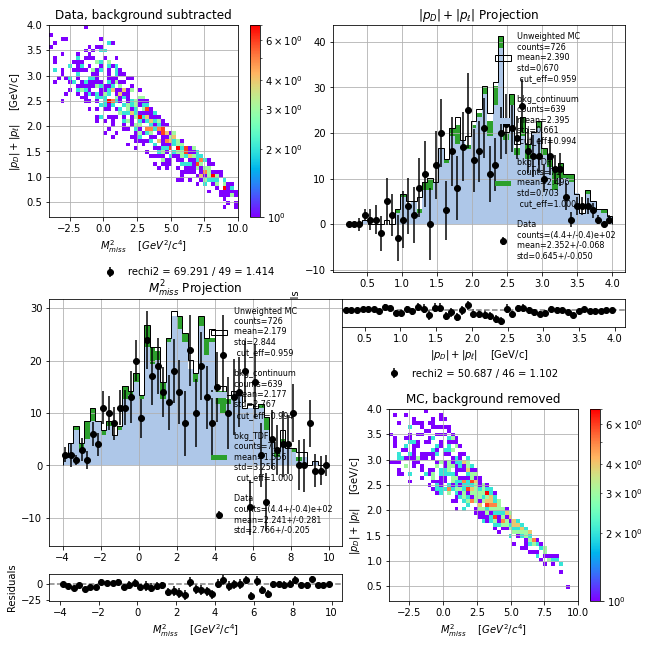

In [16]:
# subtract the scaled sidebands in the signal region
b_mm2 = np.linspace(-4,10,50)
b_pDl = np.linspace(0.2,4,50)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 42/50}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': True,
          'mask': ['bkg_FakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

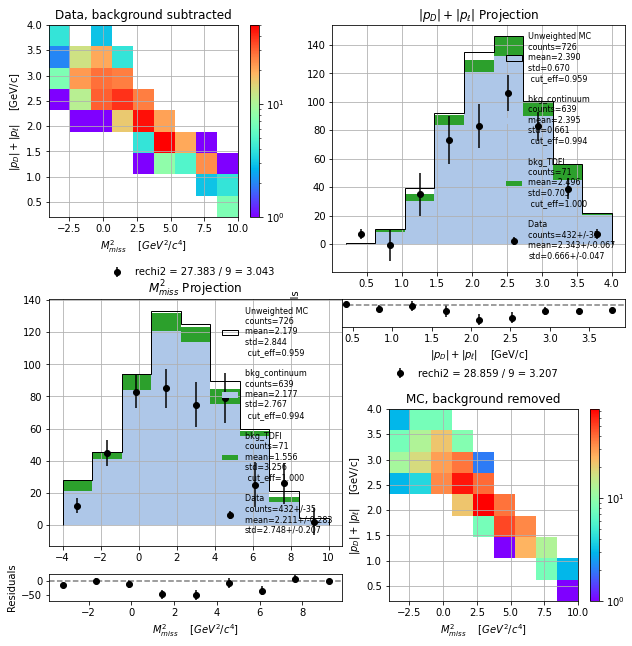

In [19]:
# subtract the scaled sidebands in the signal region
b_mm2 = np.linspace(-4,10,10)
b_pDl = np.linspace(0.2,4,10)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 42/50}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': True,
          'mask': ['bkg_FakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

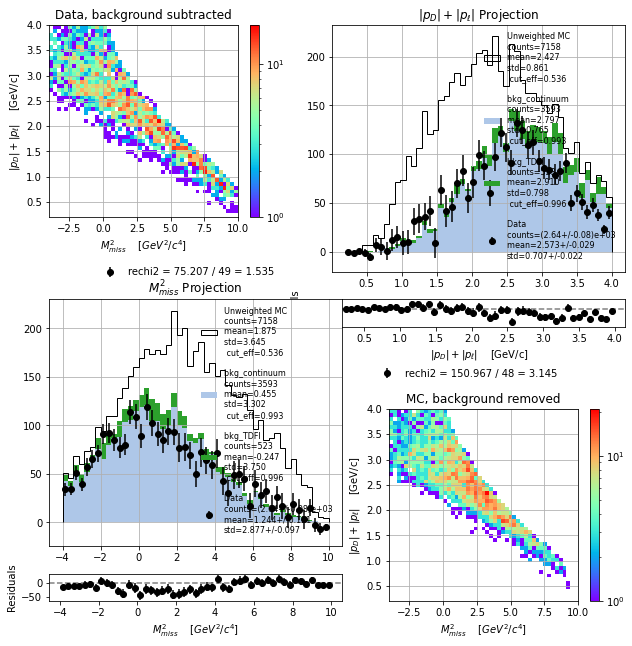

In [39]:
# subtract the scaled sidebands in the signal region
b_mm2 = np.linspace(-4,10,50)
b_pDl = np.linspace(0.2,4,50)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 42/50}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': True,
          'mask': ['bkg_FakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

## Create continuum template

In [8]:
Dsb = df_bestSelected_mc.query('D_M<1.83 or D_M>1.9').copy()
D_sig = df_bestSelected_mc.query('1.83<D_M<1.9').copy()

# Define the fitting range and number of bins, 'p_D_l'
start = 0.5 # 0.8 before adding fakeD
end = 5
num_bins = 40

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -12 # -1.1 before adding fakeD
end = 9.5 # 8.6 before adding fakeD
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

bin_threshold = 1

In [31]:
test_histograms = {}
test_staterr = {}
for name, df in {'D_sig':D_sig,'Dsb':Dsb,'true_cont':samples['bkg_continuum']}.items():

    (counts, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                              df['p_D_l'],
                                              bins=[MM2_bins, p_D_l_bins],
                                              weights=df['__weight__'])

    (staterr_squared, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                                       df['p_D_l'],
                                                       bins=[MM2_bins, p_D_l_bins],
                                                       weights=df['__weight__']**2)
    test_histograms[name] = counts
    test_staterr[name] = np.sqrt(staterr_squared)

In [32]:
continuum_2d = test_histograms['D_sig'] - 0.5*test_histograms['Dsb']
continuum_mod = np.where(continuum_2d < 0, 0, continuum_2d)

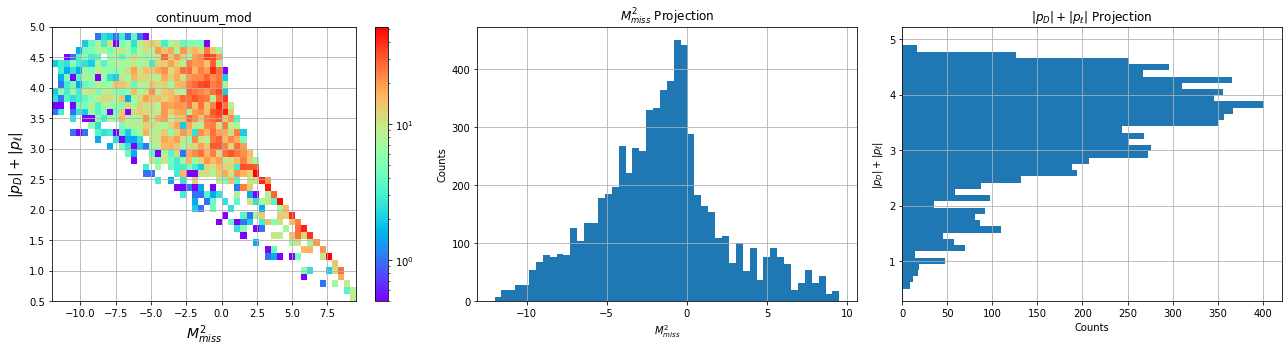

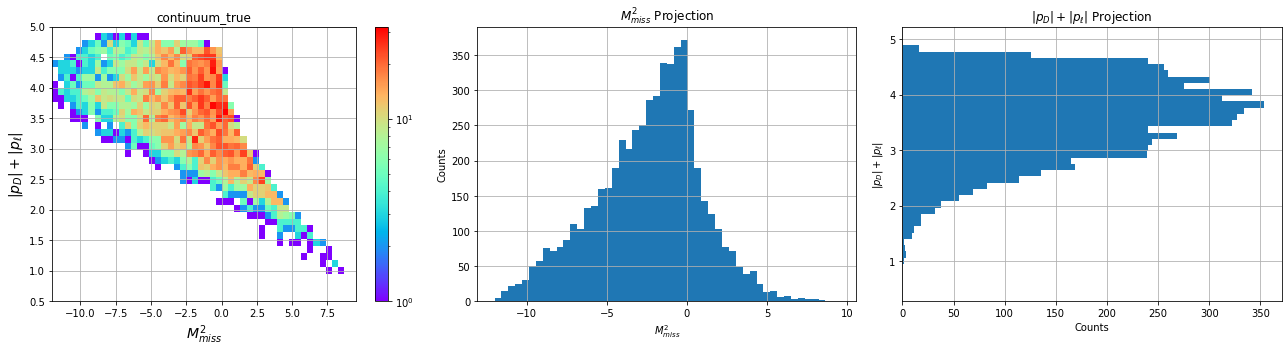

In [33]:
hists = {'continuum_mod': continuum_mod, 'continuum_true':test_histograms['true_cont']}

for name, hist in hists.items():
    # Compute projections
    x_projection = hist.sum(axis=1)  # Sum along the y-axis
    y_projection = hist.sum(axis=0)  # Sum along the x-axis

    # Plot the 2D histogram
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # 2D Histogram
    im = ax[0].imshow(hist.T, origin='lower', aspect='auto', 
                     cmap='rainbow', norm=colors.LogNorm(),
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    fig.colorbar(im, ax=ax[0])
    ax[0].set_title(name)
    ax[0].set_xlabel('$M_{miss}^2$', fontsize=14)
    ax[0].set_ylabel('$|p_D| + |p_{\ell}|$', fontsize=14)
    ax[0].grid()

    # X Projection
    ax[1].bar(xedges[:-1], x_projection, width=np.diff(xedges), align='edge')
    ax[1].set_title('$M_{miss}^2$ Projection')
    ax[1].set_xlabel('$M_{miss}^2$')
    ax[1].set_ylabel('Counts')
    ax[1].grid()

    # Y Projection
    ax[2].barh(yedges[:-1], y_projection, height=np.diff(yedges), align='edge')
    ax[2].set_title('$|p_D| + |p_{\ell}|$ Projection')
    ax[2].set_xlabel('Counts')
    ax[2].set_ylabel('$|p_D| + |p_{\ell}|$')
    ax[2].grid()

    plt.tight_layout()
    plt.show()

## Lepton correction

In [7]:
efficiency_e_table = pd.read_csv('~/B2SW/2024_OleMiss/systematics_framework/correction-tables/MC15/run_independent/PID/coarse_theta_binning/efficiency/e_efficiency_table.csv')
efficiency_e_table

,phsp_bin_idx,threshold,channel,n_in_comb,chi2,pvalue,is_final_comb,is_best_available,n_duplicates,is_unique,...,data_MC_uncertainty_statsys_dn,data_MC_uncertainty_statsys_up,rel_data_MC_uncertainty_stat_dn,rel_data_MC_uncertainty_stat_up,rel_data_MC_uncertainty_sys_dn,rel_data_MC_uncertainty_sys_up,rel_data_MC_uncertainty_statsys_dn,rel_data_MC_uncertainty_statsys_up,data_MC_DISTsys_dn,data_MC_DISTsys_up
0,NaN,0.50,jpsill_VS_eell_VS_eegamma,3,NaN,NaN,True,True,0,True,...,0.001742,0.002292,0.016717,0.016797,0.175815,0.231753,0.176608,0.232361,0.000000,0.0
1,NaN,0.50,jpsill_VS_eell_VS_eegamma,3,NaN,NaN,True,True,0,True,...,0.009143,0.017781,0.008894,0.008949,0.911959,1.773646,0.912002,1.773669,0.000000,0.0
2,NaN,0.50,jpsill_VS_eell_VS_eegamma,3,NaN,NaN,True,True,0,True,...,0.007895,0.000544,0.054222,0.054061,0.783194,0.000000,0.785069,0.054061,0.007877,0.0
3,NaN,0.50,jpsill_VS_eell_VS_eegamma,3,NaN,NaN,True,True,0,True,...,0.009262,0.000276,0.027743,0.027448,0.921046,0.000000,0.921464,0.027448,0.009258,0.0
4,NaN,0.50,jpsill_VS_eell_VS_eegamma,3,NaN,NaN,True,True,0,True,...,0.000338,0.000364,0.003975,0.003997,0.033591,0.036207,0.033825,0.036427,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,208.0,0.99,eegamma,1,-1.0,-1.0,False,True,0,True,...,0.016502,0.016502,0.588662,0.588662,1.603855,1.603855,1.708471,1.708471,0.000000,0.0
3268,211.0,0.99,eegamma,1,-1.0,-1.0,False,True,0,True,...,0.095886,0.095886,0.359123,0.359123,10.429960,10.429960,10.436141,10.436141,0.000000,0.0
3269,210.0,0.99,eegamma,1,-1.0,-1.0,False,True,0,True,...,0.048495,0.048495,1.493169,1.493169,4.796632,4.796632,5.023668,5.023668,0.000000,0.0
3270,213.0,0.99,eegamma,1,-1.0,-1.0,False,True,0,True,...,0.096099,0.096099,0.359135,0.359135,10.453701,10.453701,10.459868,10.459868,0.000000,0.0


## Hadron corrections

In [18]:
sys_path = '/group/belle2/dataprod/Systematics/systematic_corrections_framework/scripts/'

sys.path.insert(1, sys_path)

import os
import efficiency_table as et
import weight_table as wm
import process_tables as pt
import show_db_content as sdb
import show_variables as sv
import show_collections as sc
from IPython.display import HTML

In [8]:
var_table = sv.show_ntuple_variables(particle_type='K', data_query=["MC15ri_1"], type='html')
HTML(var_table)

,Global PIDs,PID BDTs,CMS Frame,Detector hits,PID log(Likelihood),Track Isolation,Uncategorized
0,deuteronID,pidChargedBDTScore_mu,phiCMS,nSVDHits,pidLogLikelihoodOf2212FromTOP,minET2ETIsoScore,firstCDCLayer
1,electronID_noSVD_noTOP,pidPairChargedBDTScore_mu_pi,cosThetaCMS,nPXDHits,pidLogLikelihoodOf13FromCDC,,pz
2,pionIDNN,pidChargedBDTScore_pi,pzCMS,nCDCHits,pidLogLikelihoodOf321FromSVD,,mcPDG
3,pionID,pidChargedBDTScore_K,pCMS,,pidLogLikelihoodOf13FromTOP,,clusterE9E21
4,kaonIDNN,pidChargedBDTScore_e,ECMS,,pidLogLikelihoodOf2212FromSVD,,phi
5,protonID,pidPairChargedBDTScore_e_pi,thetaCMS,,pidLogLikelihoodOf11FromKLM,,mcErrors
6,kaonID,pidChargedBDTScore_p,pyCMS,,pidLogLikelihoodOf211FromARICH,,clusterEoP
7,electronID,,pxCMS,,pidLogLikelihoodOf211FromECL,,clusterE
8,electronID_noSVD,,ptCMS,,pidLogLikelihoodOf1000010020FromCDC,,clusterAbsZernikeMoment51
9,muonID,,,,pidLogLikelihoodOf11FromSVD,,clusterLAT


In [ ]:
ratio_cfg = {
    "cut": "kaonID > 0.9",
    "particle_type": "K",
    "data_collection": "proc13+prompt",
    "mc_collection": "MC15ri",
    "track_variables": ["p", "cosTheta", "charge"],
    "precut": "",
    "binning": [np.linspace(0.2, 4, 11),
               [-0.866, -0.682, -0.4226, -0.1045, 0.225, 0.5, 0.766, 0.8829, 0.9563],
               [-2, 0, 2]]
}
efficiency_obj = wm.produce_data_mc_ratio(**ratio_cfg)
efficiency_obj.plot()

In [ ]:
efficiency_K_table = efficiency_obj.create_weights()
efficiency_K_table

In [ ]:
os.makedirs('tables/', exist_ok=True)
efficiency_K_table.to_csv('tables/k_efficiency.csv', index=None)

In [19]:
# To load the CSV table:
efficiency_K_table = pd.read_csv('tables/k_efficiency.csv', index_col=None)

In [ ]:
ratio_cfg = {
    "cut": "kaonID > 0.9",
    "particle_type": "pi",
    "data_collection": "proc13+prompt",
    "mc_collection": "MC15ri",
    "track_variables": ["p", "cosTheta", "charge"],
    "precut": "",
    "binning": [np.linspace(0.2, 4, 11),
               [-0.866, -0.682, -0.4226, -0.1045, 0.225, 0.5, 0.766, 0.8829, 0.9563],
               [-2, 0, 2]]
}
pi_K_fake_obj = wm.produce_data_mc_ratio(**ratio_cfg)
pi_K_fake_obj.plot()

In [ ]:
pi_K_fake_table = pi_K_fake_obj.create_weights()
pi_K_fake_table.to_csv('tables/pi_K_fake.csv', index=None)

In [20]:
# To load the CSV table:
pi_K_fake_table = pd.read_csv('tables/pi_K_fake.csv', index_col=None)

## Apply corrections

In [21]:
import warnings
from sysvar import add_weights_to_dataframe

e_tables = {(11, 11): efficiency_e_table,
            (11, 211): pi_e_fake_table
}
e_thresholds = {11: ('pidChargedBDTScore_e', 0.9)}

Welcome to JupyROOT 6.26/14


In [22]:
K_charge_mapping = {1: 321, -1: -321}
pi_charge_mapping = {1: 211, -1: -211}
# Creating the new column using map
df_bestSelected_mc['D_K_PDG'] = df_bestSelected_mc['D_K_charge'].map(K_charge_mapping)
df_bestSelected_mc['D_pi1_PDG'] = df_bestSelected_mc['D_pi1_charge'].map(pi_charge_mapping)
df_bestSelected_mc['D_pi2_PDG'] = df_bestSelected_mc['D_pi2_charge'].map(pi_charge_mapping)
df_bestSelected_mc = df_bestSelected_mc.reset_index() # for a bug in add_weights_to_dataframe

In [23]:
df_bestSelected_mc[['D_K_PDG','D_K_charge','D_pi1_PDG','D_pi1_charge']].value_counts()

D_K_PDG  D_K_charge  D_pi1_PDG  D_pi1_charge
-321     -1.0         211        1.0            24633
 321      1.0        -211       -1.0            22494
Name: count, dtype: int64

Required variables: ['ell_p', 'ell_charge', 'ell_theta', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 87.8%


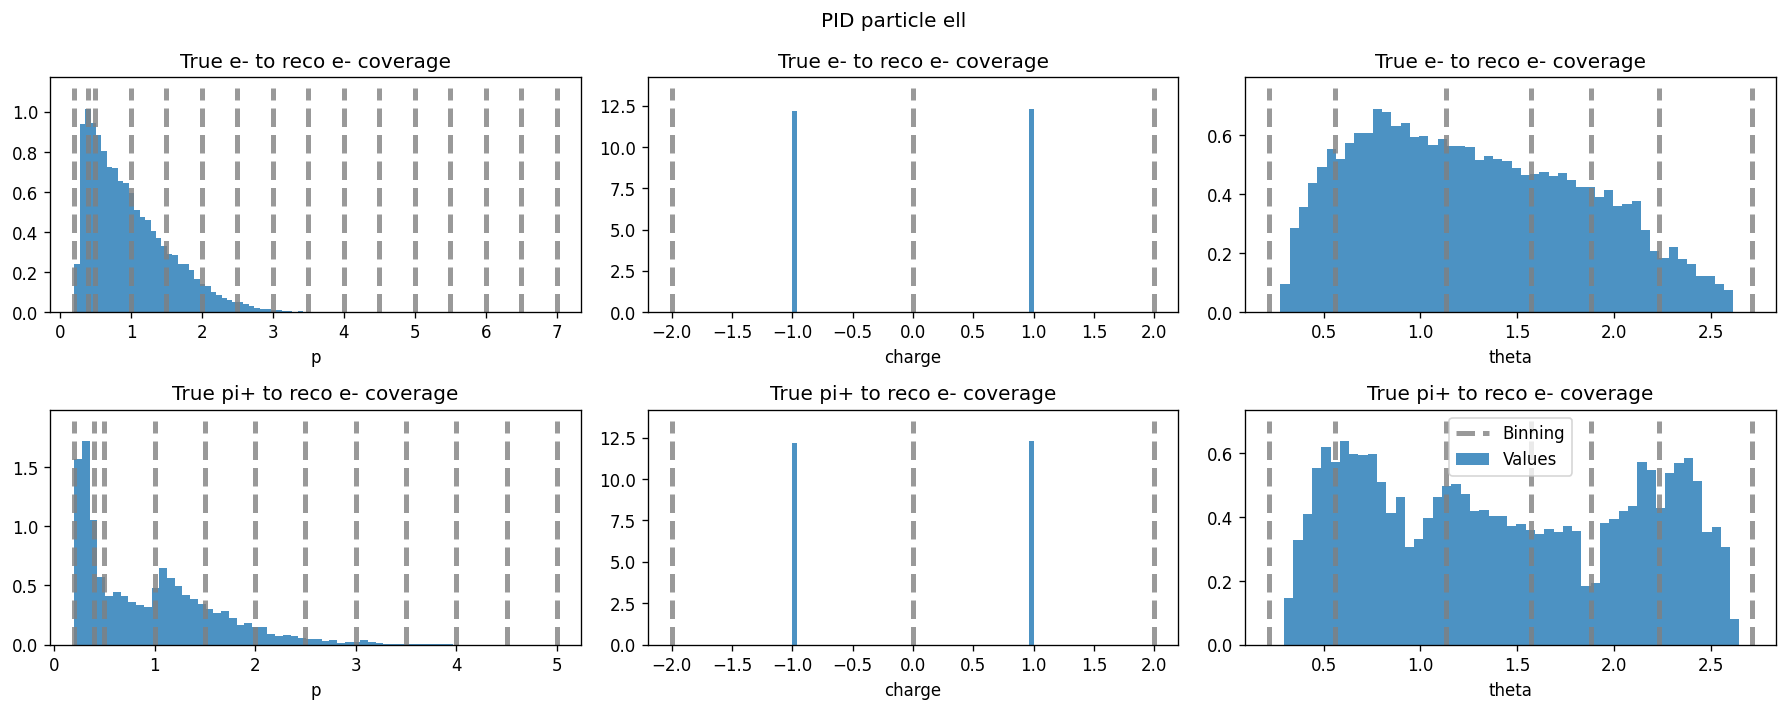

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    add_weights_to_dataframe('ell',
                             df_bestSelected_mc,
                             systematic='custom_PID',
                             custom_tables=e_tables,
                             custom_thresholds=e_thresholds,
                             show_plots=True,
                             sys_seed=0)

In [ ]:
df_bestSelected_mc[['ell_p', 'ell_charge', 'ell_theta', 'ell_PDG', 'ell_mcPDG']].isna().sum()

In [25]:
df_bestSelected_mc.query('ell_Weight==1')[['ell_Weight'] + [f'ell_Weight_{i}' for i in range(100)]]

,ell_Weight,ell_Weight_0,ell_Weight_1,ell_Weight_2,ell_Weight_3,ell_Weight_4,ell_Weight_5,ell_Weight_6,ell_Weight_7,ell_Weight_8,...,ell_Weight_90,ell_Weight_91,ell_Weight_92,ell_Weight_93,ell_Weight_94,ell_Weight_95,ell_Weight_96,ell_Weight_97,ell_Weight_98,ell_Weight_99
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
32,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47113,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
47117,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
47120,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
47121,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
k_tables = {(321, 321): efficiency_K_table,
            (321, 211): pi_K_fake_table}
k_thresholds = {321: ('kaonID', 0.9)}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    add_weights_to_dataframe('D_K',
                             df_bestSelected_mc,
                             systematic='custom_PID',
                             custom_tables=k_tables,
                             custom_thresholds=k_thresholds,
                             show_plots=True)

In [ ]:
df_bestSelected_mc.query('D_K_Weight==1')[['D_K_Weight'] + [f'D_K_Weight_{i}' for i in range(100)]]

In [ ]:
df_bestSelected_mc['PIDWeight'] = df_bestSelected_mc[['ell_Weight', 'D_K_Weight']].product(axis=1)

In [30]:
df_bestSelected_mc['PIDWeight'] = df_bestSelected_mc['ell_Weight']

/tmp/ipykernel_53098/3500322995.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestSelected_mc['PIDWeight'] = df_bestSelected_mc['ell_Weight']


In [31]:
samples=util.get_dataframe_samples_new(df_bestSelected_mc, 'e', template=False)
mpl=util.mpl(samples,df_bestSelected_data)

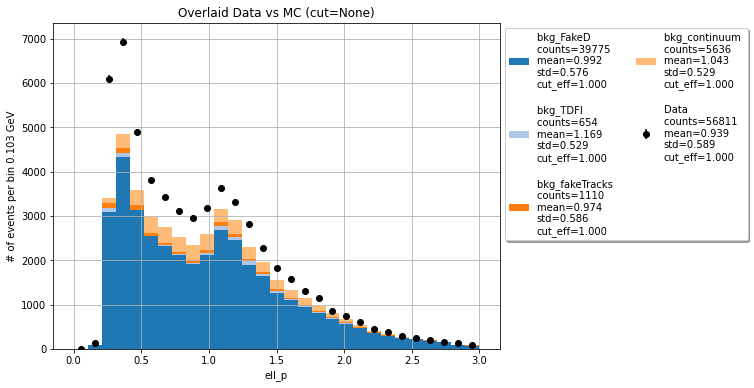

In [32]:
b1 = np.linspace(0,3,30)
mpl.plot_data_mc_overlaid(variable='ell_p',bins=b1,cut=None,scale=[1, 42/50],correction=True)

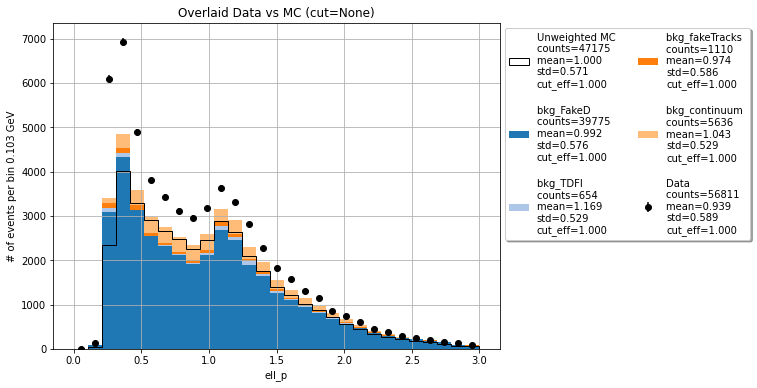

In [37]:
b1 = np.linspace(0,3,30)
mpl.plot_data_mc_overlaid(variable='ell_p',bins=b1,cut=None,scale=[1, 42/50],correction=True)